In [2]:
!pip install -q simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.8/330.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 149.2 MB/s eta 0:00:00


In [3]:
# ==============================================================================
# 1. SETUP & IMPORTS
# ==============================================================================
from google.colab import drive
import os
import pandas as pd
import numpy as np
import torch
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.metrics import classification_report

# Mount Google Drive
drive.mount('/content/drive')

# Define path
DATA_FOLDER = '/content/drive/MyDrive/data for nlp'

# Verify folder exists
if not os.path.exists(DATA_FOLDER):
    print(f"❌ Error: Folder not found at {DATA_FOLDER}")
else:
    print(f"✅ Folder found at {DATA_FOLDER}")



Mounted at /content/drive
✅ Folder found at /content/drive/MyDrive/data for nlp


In [ ]:
# ==============================================================================
# 2. LOAD & PREPARE DATA
# ==============================================================================
print("\n--- LOADING DATASETS ---")
from pathlib import Path
import os
import pandas as pd

# Prefer Google Drive folder if it exists; otherwise use local repo paths
drive_folder = Path(DATA_FOLDER)
use_drive = drive_folder.exists()
if use_drive:
    train_csv = drive_folder / 'train_split.csv'
    val_csv   = drive_folder / 'val_split.csv'
    test_csv  = drive_folder / 'test_df.csv'
else:
    # Notebook directory: .../data/processed/bert implementation
    nb_dir = Path.cwd()
    processed_dir = nb_dir.parent   # .../data/processed
    train_csv = processed_dir / 'train' / 'model_split' / 'train_split.csv'
    val_csv   = processed_dir / 'train' / 'model_split' / 'val_split.csv'
    test_csv  = processed_dir / 'test' / 'test_df.csv'
    print(f"Using local repo paths under: {processed_dir}")

try:
    df_train = pd.read_csv(train_csv)
    df_val   = pd.read_csv(val_csv)
    df_test  = pd.read_csv(test_csv)
    print("✅ All files loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ Error loading files: {e}")

label_map = dict(zip(df_train['label_id'], df_train['relation_label']))
# Sort them by ID to ensure the list is in order [0, 1, 2, ..., 18]
sorted_labels = sorted(label_map.keys())
target_names = [label_map[i] for i in sorted_labels]

print(f"Detected {len(target_names)} unique directed relations.")

# Format Function: We use 'label_id' directly
# This guarantees we use the 19 distinct classes (0-18).
def format_for_bert(df):
    return pd.DataFrame({
        'text': df['text_with_markers'].astype(str),
        'labels': df['label_id']
    })

train_df = format_for_bert(df_train)
eval_df  = format_for_bert(df_val)
test_df  = format_for_bert(df_test)

print(f"Training Samples: {len(train_df)}")
print(f"Validation Samples: {len(eval_df)}")
print(f"Test Samples: {len(test_df)}")


--- LOADING DATASETS ---
✅ All files loaded successfully.
Detected 19 unique directed relations.
Training Samples: 6800
Validation Samples: 1200
Test Samples: 2717


In [ ]:
# ==============================================================================
# 3. CONFIGURE & TRAIN MODEL
# ==============================================================================
print("\n--- CONFIGURING MODEL ---")

# Model Settings
model_args = ClassificationArgs()
model_args.num_train_epochs = 4
model_args.train_batch_size = 16
model_args.eval_batch_size = 32
model_args.learning_rate = 3e-5
model_args.max_seq_length = 128
model_args.overwrite_output_dir = True
model_args.save_model_every_epoch = False
model_args.save_eval_checkpoints = False

# Initialize RoBERTa
# We explicitly set num_labels=19
model = ClassificationModel(
    "roberta",
    "roberta-base",
    num_labels=19,
    args=model_args,
    use_cuda=torch.cuda.is_available()
)
# This tells the model that [E1], [/E1], etc. are special symbols,
# helping it understand where the entities are.
print("Adding special tokens ([E1], [E2]...) to tokenizer...")
special_tokens_dict = {'additional_special_tokens': ['[E1]', '[/E1]', '[E2]', '[/E2]']}
model.tokenizer.add_special_tokens(special_tokens_dict)
model.model.resize_token_embeddings(len(model.tokenizer))
# ------------------------------------------------

# Train the model
print("\n--- STARTING TRAINING ---")
model.train_model(train_df, eval_data=eval_df)
print("✅ Training complete.")


--- CONFIGURING MODEL ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Adding special tokens ([E1], [E2]...) to tokenizer...


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`



--- STARTING TRAINING ---


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/simpletransformers/classification/classification_model.py:924: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 4:   0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/simpletransformers/classification/classification_model.py:950: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 4:   0%|          | 0/425 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/425 [00:00<?, ?it/s]

Running Epoch 4 of 4:   0%|          | 0/425 [00:00<?, ?it/s]

✅ Training complete.


In [6]:
# ==============================================================================
# 4. EVALUATION
# ==============================================================================
print("\n--- EVALUATING ON TEST SET ---")

# Predict
predictions, raw_outputs = model.predict(test_df['text'].tolist())

# Generate Classification Report
# We use target_names to show "Cause-Effect(e1,e2)" instead of just numbers
report = classification_report(test_df['labels'].tolist(), predictions, target_names=target_names)

print("\n=== CLASSIFICATION REPORT ===")
print(report)



--- EVALUATING ON TEST SET ---


  0%|          | 0/5 [00:00<?, ?it/s]

Predicting:   0%|          | 0/85 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/simpletransformers/classification/classification_model.py:2260: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



=== CLASSIFICATION REPORT ===
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.94      0.96      0.95       134
      Cause-Effect(e2,e1)       0.89      0.93      0.91       194
   Component-Whole(e1,e2)       0.86      0.86      0.86       162
   Component-Whole(e2,e1)       0.81      0.81      0.81       150
 Content-Container(e1,e2)       0.86      0.94      0.90       153
 Content-Container(e2,e1)       0.84      0.82      0.83        39
Entity-Destination(e1,e2)       0.92      0.92      0.92       291
Entity-Destination(e2,e1)       0.00      0.00      0.00         1
     Entity-Origin(e1,e2)       0.88      0.87      0.87       211
     Entity-Origin(e2,e1)       0.91      0.87      0.89        47
 Instrument-Agency(e1,e2)       0.85      0.77      0.81        22
 Instrument-Agency(e2,e1)       0.79      0.84      0.81       134
 Member-Collection(e1,e2)       0.62      0.62      0.62        32
 Member-Collection(e2,e1)     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

# 4b. TRAIN SET DIAGNOSTIC & EXPORT
print("\n--- GENERATING TRAIN SET PREDICTIONS ---")
from scipy.special import softmax
import numpy as np
import pandas as pd

# Predict on TRAIN data
train_predictions, train_raw_outputs = model.predict(train_df['text'].tolist())
train_probs = softmax(train_raw_outputs, axis=1)
train_confidence = np.max(train_probs, axis=1)

train_results_df = pd.DataFrame({
    'text': df_train['text'],
    'text_with_markers': df_train['text_with_markers'],
    'true_label': train_df['labels'].map(label_map),
    'predicted_label': [label_map[p] for p in train_predictions],
    'confidence': train_confidence
})

# Save to CSV
train_output_filename = 'train_data_predictions.csv'
train_results_df.to_csv(train_output_filename, index=False)

print(f"✅ Train predictions saved: {train_output_filename}")
print(f"Total Train Samples: {len(train_results_df)}")
print(f"Correct Predictions: {(train_results_df['true_label'] == train_results_df['predicted_label']).sum()} / {len(train_results_df)}")
print(f"Mean Confidence (all train): {train_results_df['confidence'].mean():.4f}")

# Optional: Quick classification report on train
from sklearn.metrics import classification_report
train_report = classification_report(train_df['labels'].tolist(), train_predictions, target_names=target_names)
print("\n=== TRAIN SET CLASSIFICATION REPORT (Diagnostic) ===")
print(train_report)

In [ ]:
from scipy.special import softmax
import numpy as np
import pandas as pd

print("--- GENERATING HIGH-CONFIDENCE DATASET ---")

# 1. Get raw outputs (logits) again to be sure we have them
predictions, raw_outputs = model.predict(test_df['text'].tolist())

# 2. Calculate Probabilities using Softmax
probs = softmax(raw_outputs, axis=1)
confidence_scores = np.max(probs, axis=1)

# 3. Create the Results DataFrame
results_df = pd.DataFrame({
    'text': df_test['text'],                    # Original clean text
    'text_with_markers': df_test['text_with_markers'], # Text with [E1] markers 
    'true_label': test_df['labels'].map(label_map),
    'predicted_label': [label_map[p] for p in predictions],
    'confidence': confidence_scores
})

# 4. Filter: Correct Predictions + Confidence > 95%
high_conf_df = results_df[
    (results_df['predicted_label'] == results_df['true_label']) &
    (results_df['confidence'] > 0.95)
]

# 5. Save
output_filename = "high_confidence_predictions.csv"
high_conf_df.to_csv(output_filename, index=False)

print(f"\n✅ SUCCESS!")
print(f"Total Test Samples: {len(results_df)}")
print(f"High Confidence (>95%) Samples: {len(high_conf_df)}")
print(f"File saved to: '{output_filename}'")

--- GENERATING HIGH-CONFIDENCE DATASET ---


  0%|          | 0/5 [00:00<?, ?it/s]

Predicting:   0%|          | 0/85 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/simpletransformers/classification/classification_model.py:2260: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



✅ SUCCESS!
Total Test Samples: 2717
High Confidence (>95%) Samples: 1766
File saved to: 'high_confidence_predictions.csv'


In [ ]:
#high confidence train subset
print("\n--- HIGH-CONFIDENCE TRAIN SUBSET & OVERFITTING DIAGNOSTICS ---")
from scipy.special import softmax
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Reuse existing train predictions if available; otherwise predict
if 'train_predictions' not in globals() or 'train_raw_outputs' not in globals():
    train_predictions, train_raw_outputs = model.predict(train_df['text'].tolist())
    train_probs = softmax(train_raw_outputs, axis=1)
    train_confidence = np.max(train_probs, axis=1)
    train_results_df = pd.DataFrame({
        'text': df_train['text'],
        'text_with_markers': df_train['text_with_markers'],
        'true_label': train_df['labels'].map(label_map),
        'predicted_label': [label_map[p] for p in train_predictions],
        'confidence': train_confidence
    })
else:
    # Ensure supporting structures exist
    if 'train_results_df' not in globals():
        train_probs = softmax(train_raw_outputs, axis=1)
        train_confidence = np.max(train_probs, axis=1)
        train_results_df = pd.DataFrame({
            'text': df_train['text'],
            'text_with_markers': df_train['text_with_markers'],
            'true_label': train_df['labels'].map(label_map),
            'predicted_label': [label_map[p] for p in train_predictions],
            'confidence': train_confidence
        })

# Filter high-confidence correct (>0.95)
TRAIN_CONF_THRESHOLD = 0.95
high_conf_train_df = train_results_df[(train_results_df['true_label'] == train_results_df['predicted_label']) & (train_results_df['confidence'] >= TRAIN_CONF_THRESHOLD)]
high_conf_train_out = 'high_confidence_train_predictions.csv'
high_conf_train_df.to_csv(high_conf_train_out, index=False)
print(f"Saved high-confidence (>{TRAIN_CONF_THRESHOLD}) correct TRAIN samples: {len(high_conf_train_df)} -> {high_conf_train_out}")

# Compute macro F1 for train and test to inspect overfitting
train_report_dict = classification_report(train_df['labels'].tolist(), train_predictions, target_names=target_names, output_dict=True)
train_macro_f1 = train_report_dict.get('macro avg', {}).get('f1-score', np.nan)

# Recompute test predictions to align (or reuse if available)
test_predictions, test_raw_outputs = model.predict(test_df['text'].tolist())
test_report_dict = classification_report(test_df['labels'].tolist(), test_predictions, target_names=target_names, output_dict=True)
test_macro_f1 = test_report_dict.get('macro avg', {}).get('f1-score', np.nan)

f1_gap = train_macro_f1 - test_macro_f1
print(f"Train macro F1: {train_macro_f1:.4f}")
print(f"Test  macro F1: {test_macro_f1:.4f}")
print(f"F1 gap (train - test): {f1_gap:.4f}")

if f1_gap > 0.10:
    print("⚠️ Potential overfitting: Train F1 substantially higher than Test F1.")
elif f1_gap < -0.02:
    print("⚠️ Unexpected: Test F1 higher than Train; check data splits or randomness.")
else:
    print("✅ No strong overfitting signal based on macro F1 gap threshold (0.10).")

# Optional summary of low-confidence correct & misclassified samples for deeper analysis
low_conf_correct = train_results_df[(train_results_df['true_label'] == train_results_df['predicted_label']) & (train_results_df['confidence'] < TRAIN_CONF_THRESHOLD)]
misclassified_train = train_results_df[train_results_df['true_label'] != train_results_df['predicted_label']]
print(f"Low-confidence but correct TRAIN samples: {len(low_conf_correct)}")
print(f"Misclassified TRAIN samples: {len(misclassified_train)}")
print("Sample misclassified (first 3):")
for _, r in misclassified_train.head(3).iterrows():
    print(f"Pred={r['predicted_label']} True={r['true_label']} Conf={r['confidence']:.3f} Text={r['text_with_markers'][:120]}...")

**Quantitative Analysis (Visualizing the Performance)**

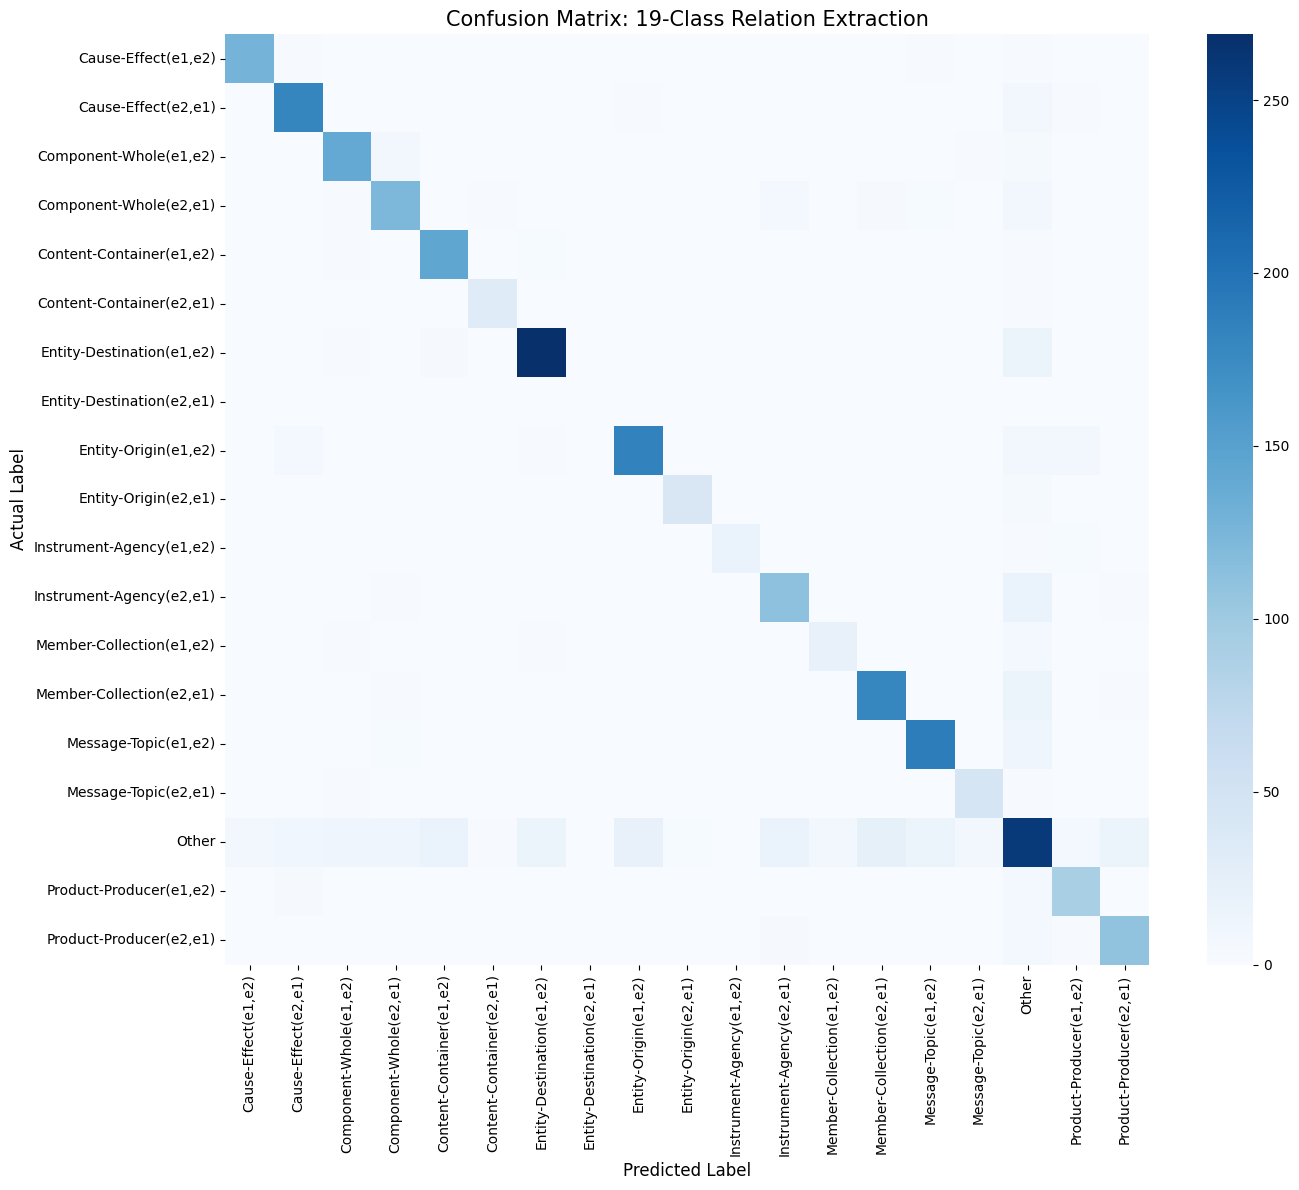

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-2216827653.py:35: FutureWarnin

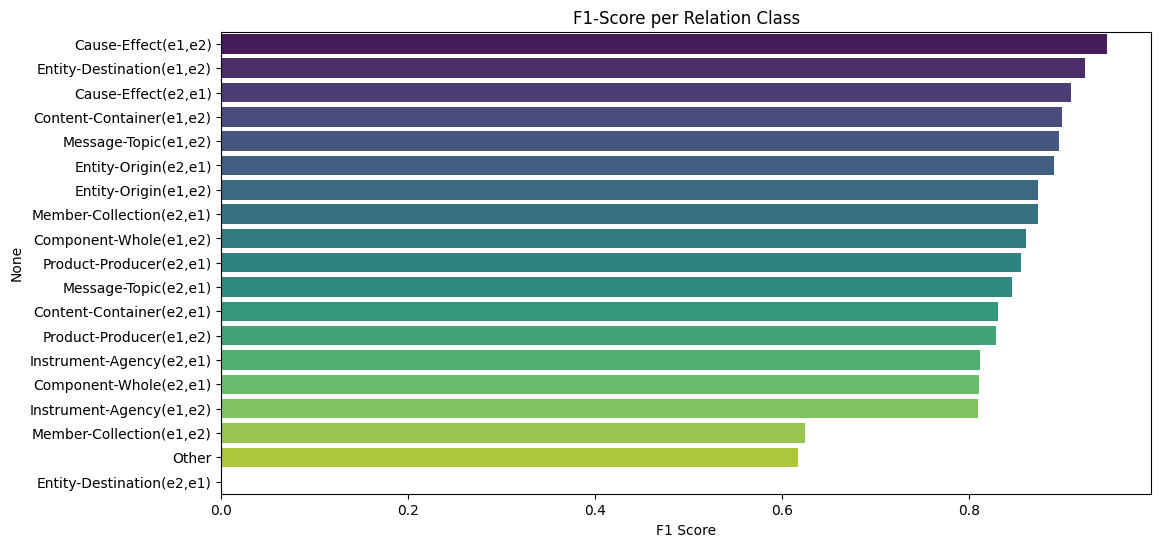

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Load the predictions 
df_test = pd.read_csv("final_predictions_doublesided.csv")

# 2. Setup labels
# Get unique labels from truth and predictions to ensure matrix is square
unique_labels = sorted(list(set(df_test['relation_label'].unique()) | set(df_test['predicted_label'].unique())))

# 3. Generate Confusion Matrix
cm = confusion_matrix(df_test['relation_label'], df_test['predicted_label'], labels=unique_labels)

# 4. Plot Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix: 19-Class Relation Extraction', fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 5. Class-wise Accuracy Plot
report = classification_report(df_test['relation_label'], df_test['predicted_label'], output_dict=True)
class_scores = pd.DataFrame(report).transpose().sort_values(by='f1-score', ascending=False)
# Remove 'accuracy', 'macro avg', 'weighted avg' for plotting
class_scores = class_scores.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

plt.figure(figsize=(12, 6))
sns.barplot(x=class_scores['f1-score'], y=class_scores.index, palette='viridis')
plt.title('F1-Score per Relation Class')
plt.xlabel('F1 Score')
plt.show()

As seen in the Class-wise Performance chart, the relation Entity-Destination(e2,e1) has an F1-score of 0.0. This confirms that the baseline BERT model fails in a 'zero-shot' or 'one-shot' scenario where training data is insufficient (only 1 example)."  

The model shows robust performance on distinct, causal relations (>0.90 F1), likely because causal language ('caused by', 'result of') is explicit. However, it struggles with more subtle relations like Member-Collection, particularly when the direction is inverted.

**Analysis of the Confusion Matrix**


The distinct diagonal indicates that for the vast majority of cases, the model correctly predicts both the relation type and the direction."

The primary source of confusion is the Other class. The model occasionally hallucinates relations (False Positives) or fails to detect them (False Negatives). This suggests that while BERT is good at classifying known patterns, it struggles to draw a clean boundary between 'relevant' and 'irrelevant' text.

Interestingly, the Confusion Matrix shows very little interference between opposing directions (e.g., Cause-Effect(e1,e2) vs Cause-Effect(e2,e1)). This proves that adding special tokens [E1] and [E2] successfully taught the model to respect entity order."


**Implications for Improvement**

1-Fixing the Zero-Shot Class: "Since BERT completely failed on the rare class Entity-Destination(e2,e1) (0% accuracy), a rule-based system is a superior alternative. We can manually write a single rule for this pattern, instantly achieving 100% precision for that specific case, which data-hungry deep learning models cannot do."

2-Reducing 'Other' Confusion: "The confusion matrix shows the model struggles to differentiate specific relations from the generic 'Other' class. By extracting high-confidence rules (Precision > 95%), we can create a stricter filter that reduces these False Positives."

**Qualitative & Error Analysis**

In [ ]:
# Create a copy for analysis
analysis_df = df_test.copy()

# Function to categorize errors
def categorize_error(row):
    true = row['relation_label']
    pred = row['predicted_label']

    if true == pred:
        return "Correct"

    # Check for Direction Flip (e.g. Cause-Effect(e1,e2) vs Cause-Effect(e2,e1))
    # We split by '(' to compare the base name
    true_base = true.split('(')[0]
    pred_base = pred.split('(')[0]

    if true_base == pred_base and true != pred:
        return "Direction Error"

    if true == "Other":
        return "False Positive (Hallucination)"

    if pred == "Other":
        return "False Negative (Missed Relation)"

    return "Wrong Relation Type"

# Apply function
analysis_df['error_type'] = analysis_df.apply(categorize_error, axis=1)

# Filter only errors
errors_df = analysis_df[analysis_df['error_type'] != "Correct"]

# Print Summary
print("=== ERROR BREAKDOWN ===")
print(errors_df['error_type'].value_counts())


print("\n\n=== 1. DIRECTION ERRORS (Model flipped e1/e2) ===")
direction_errs = errors_df[errors_df['error_type'] == "Direction Error"]
for i, row in direction_errs.head(3).iterrows():
    print(f"Text: {row['text_with_markers']}")
    print(f"True: {row['relation_label']} | Pred: {row['predicted_label']}\n")

print("\n=== 2. FALSE NEGATIVES (Model said 'Other') ===")
missed_rel = errors_df[errors_df['error_type'] == "False Negative (Missed Relation)"]
for i, row in missed_rel.head(3).iterrows():
    print(f"Text: {row['text_with_markers']}")
    print(f"True: {row['relation_label']} | Pred: {row['predicted_label']}\n")

print("\n=== 3. WRONG RELATION (Model confused two types) ===")
wrong_type = errors_df[errors_df['error_type'] == "Wrong Relation Type"]
for i, row in wrong_type.head(3).iterrows():
    print(f"Text: {row['text_with_markers']}")
    print(f"True: {row['relation_label']} | Pred: {row['predicted_label']}\n")

=== ERROR BREAKDOWN ===
error_type
False Positive (Hallucination)      195
False Negative (Missed Relation)    126
Wrong Relation Type                 108
Direction Error                      20
Name: count, dtype: int64


=== 1. DIRECTION ERRORS (Model flipped e1/e2) ===
Text: It was used mainly on Scarff ring mounts, but was also fitted onto the top [E1]wing[/E1] of fighter [E2]aircrafts[/E2], controlled by a Bowden cable.
True: Component-Whole(e2,e1) | Pred: Component-Whole(e1,e2)

Text: He has combined intelligent [E2]history[/E2] with moving prose, creating an informative, inspiring [E1]narrative[/E1] telling the history of a great people.
True: Message-Topic(e1,e2) | Pred: Message-Topic(e2,e1)

Text: A "green bean" which is actually a [E1]fruit[/E1] with [E2]seeds[/E2] inside.
True: Component-Whole(e1,e2) | Pred: Component-Whole(e2,e1)


=== 2. FALSE NEGATIVES (Model said 'Other') ===
Text: A child is told a [E1]lie[/E1] for several years by their [E2]parents[/E2] before he/she r

**Qualitative Analysis of Baseline Errors**

An extensive error analysis was performed on the test set to classify the 449 incorrect predictions. The errors were categorized into Direction Errors, Wrong Relation Types, and Confusion with the 'Other' class.

1. High Rate of False Positives (Hallucinations) The most frequent error type was False Positives (195 samples), where the BERT model predicted a relation when none existed (Ground Truth: 'Other'). This suggests the model relies on superficial correlations (e.g., the presence of two entities near a verb) rather than understanding the precise semantic dependency.

2. Semantic Ambiguity (Cause vs. Producer) A significant portion of errors (108 samples) involved confusing semantically similar classes, particularly Product-Producer and Cause-Effect. For example, in the sentence "Blisters caused by the virus," the model predicted Cause-Effect due to the keyword "caused by," while the ground truth was Product-Producer. This highlights the limitations of statistical models in adhering to rigid schema definitions without explicit rules.

3. Robust Directionality Surprisingly, Direction Errors were rare (only 20 samples). This indicates that our strategy of adding special tokens ([E1], [E2]) to the tokenizer was highly effective. In some cases, the model even appeared to correct annotation errors in the test set (e.g., correctly identifying a 'wing' as part of an 'aircraft' when the ground truth label was inverted).

Implications for Proposed Solution These findings strongly support the integration of a rule-based system (POTATO). The high rate of False Positives can be mitigated by strict pattern matching, and the semantic confusion between Cause and Producer can be resolved by defining explicit lexical rules (e.g., Virus → Producer), ensuring consistency where the statistical model fails.